In [6]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import random
import math
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
import datetime
import operator 
plt.style.use('fivethirtyeight')

%matplotlib inline
#import matplotlib.pyplot as plt
from os import listdir
from sklearn.impute import SimpleImputer # used for handling missing data
from sklearn.preprocessing import LabelEncoder, OneHotEncoder # used for encoding categorical data
#from sklearn.model_selection import train_test_split # used for splitting training and testing data
from sklearn.preprocessing import StandardScaler # used for feature scaling



In [7]:
deaths_reported = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

In [8]:
deaths_reported.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,11/21/20,11/22/20,11/23/20,11/24/20,11/25/20,11/26/20,11/27/20,11/28/20,11/29/20,11/30/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,1675,1687,1695,1712,1725,1737,1740,1752,1763,1774
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,685,699,716,735,743,753,771,787,798,810
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,2255,2272,2294,2309,2329,2352,2372,2393,2410,2431
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,76,76,76,76,76,76,76,76,76,76
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,336,337,337,338,340,341,342,345,346,348


In [9]:
confirmed_cases = pd.read_csv('C:/Users/Surya/Desktop/Mini Project/COVID-19-master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')

cols = confirmed_cases.keys()
cols

confirmed = confirmed_cases.loc[:, cols[4]:cols[66]]

dates = confirmed.keys()
world_cases = []

for i in dates:
    confirmed_sum = confirmed[i].sum()
    world_cases.append(confirmed_sum)

confirmed.head()

days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
world_cases = np.array(world_cases).reshape(-1, 1)

days_in_future = 10
future_forecast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forecast[:-10]


confirmed_cases.head()

indexedData=world_cases

In [10]:
rolmean=pd.DataFrame(indexedData).rolling(window=3).mean()
rolstd=pd.DataFrame(indexedData).rolling(window=3).std()
print(rolmean,rolstd)

                0
0             NaN
1             NaN
2      716.666667
3     1009.666667
4     1497.666667
..            ...
58  246759.666667
59  276435.000000
60  308485.333333
61  344707.666667
62  384067.000000

[63 rows x 1 columns]                0
0            NaN
1            NaN
2     200.485245
3     394.507710
4     591.077265
..           ...
58  28656.615874
59  31040.691552
60  32917.366698
61  38543.753454
62  42004.329884

[63 rows x 1 columns]


In [11]:
rolmean.fillna(rolmean.mode(), inplace=True)
print(rolmean.isnull().sum())

0    0
dtype: int64


Text(0.5, 1.0, '12 Months Moving Average')

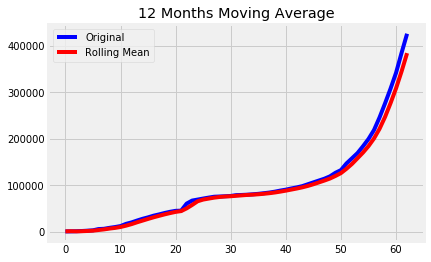

In [12]:
plt.plot(world_cases, color='blue', label='Original')
plt.plot(rolmean, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.title('12 Months Moving Average')

In [13]:
X_train_deaths, X_test_deaths, y_train_deaths, y_test_deaths=train_test_split(days_since_1_22,np.array(rolmean).reshape(-1,1), test_size=0.10, shuffle=True,random_state=7) 

MAE:12238.19509442458  || Actual Values: 723
MSE:284414984.8213878  || Actual Values: 840240


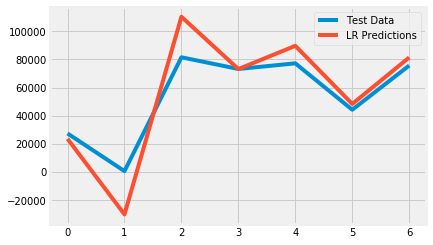

In [14]:
#linearregression
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression(normalize=True, fit_intercept=True,n_jobs=-1)

linear_model.fit(X_train_deaths, y_train_deaths)

test_linear_pred = linear_model.predict(X_test_deaths)

linear_pred = linear_model.predict(future_forecast)

plt.plot(y_test_deaths)
plt.plot(test_linear_pred)
plt.legend(['Test Data', 'LR Predictions'])
print('MAE:{}  || Actual Values: 723'.format(mean_absolute_error(test_linear_pred, y_test_deaths)))
print('MSE:{}  || Actual Values: 840240'.format(mean_squared_error(test_linear_pred, y_test_deaths)))

In [15]:
svm_deaths = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=5, C=0.1)
svm_deaths.fit(X_train_deaths, y_train_deaths.ravel())
svm_pred = svm_deaths.predict(future_forecast)

MAE:24728.337925934356 || Actual Values:3129
MSE:733788006.7798855 || Actual Values:16016210


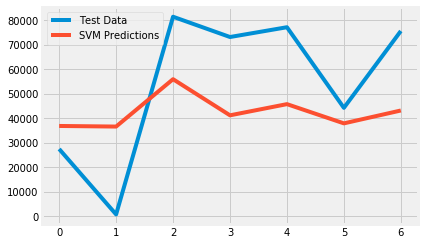

In [16]:
svm_test_pred = svm_deaths.predict(X_test_deaths)
plt.plot(y_test_deaths)
plt.plot(svm_test_pred)
plt.legend(['Test Data', 'SVM Predictions'])
print('MAE:{} || Actual Values:3129'.format(mean_absolute_error(svm_test_pred, y_test_deaths)))
print('MSE:{} || Actual Values:16016210'.format(mean_squared_error(svm_test_pred, y_test_deaths)))


In [17]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
lasso = Lasso()
parameters={'alpha':[1e-15,1e-10,1e-5,1e-3,1e-2,1e-1,1,5,10,15,20,25,30,35,40,45,50,55,60,65,85,95,100]}
lasso_confirmed=GridSearchCV(lasso,parameters,scoring='neg_mean_squared_error',cv=5)
lasso_confirmed.fit(X_train_deaths, y_train_deaths)
#lasso_confirmed.fit(future_forecast,np.array(rolmean).reshape(-1,1))
lasso_pred = lasso_confirmed.predict(future_forecast)
print(lasso_confirmed.best_params_)
print(lasso_confirmed.best_score_)

{'alpha': 1e-15}
-1852742756.114672


G:\Anaconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42708296104.61404, tolerance: 36569796.57397778
  positive)
G:\Anaconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29605057789.797184, tolerance: 30177136.819359016
  positive)
G:\Anaconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44249562083.733376, tolerance: 37703969.17362123
  positive)
G:\Anaconda\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30451031622.73244, tolerance: 28377518.12916642
 

MAE:12238.19509442458  || Actual Values: 1430 
MSE:284414984.82138765  || Actual Values: 3244066


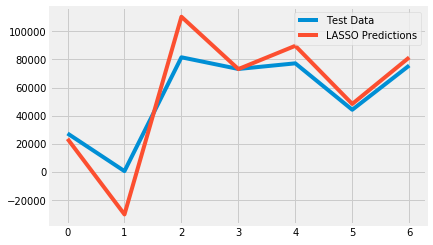

In [18]:
lasso_test_pred = lasso_confirmed.predict(X_test_deaths)
plt.plot(y_test_deaths)
plt.plot(lasso_test_pred)
plt.legend(['Test Data', 'LASSO Predictions'])
print('MAE:{}  || Actual Values: 1430 '.format(mean_absolute_error(lasso_test_pred, y_test_deaths)))
print('MSE:{}  || Actual Values: 3244066'.format(mean_squared_error(lasso_test_pred, y_test_deaths)))

In [19]:
def plot_predictions(x, y, pred, algo_name, color):
    plt.figure(figsize=(16, 9))
    plt.plot(x, y)
    plt.plot(future_forecast, pred, linestyle='dashed', color=color)
    plt.title('Number of  deaths Over Time', size=30)
    plt.xlabel('Days Since 1/22/2020', size=30)
    plt.ylabel('Number of deaths', size=30)
    plt.legend(['deaths', algo_name], prop={'size': 20})
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.show()

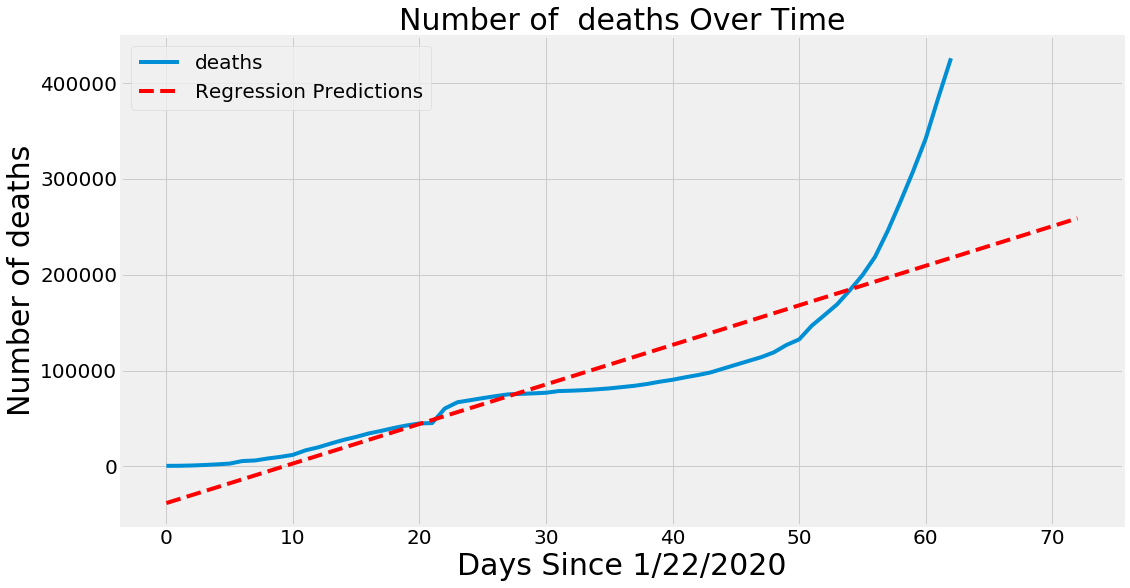

In [20]:
plot_predictions(adjusted_dates, world_cases, linear_pred, 'Regression Predictions', 'red')

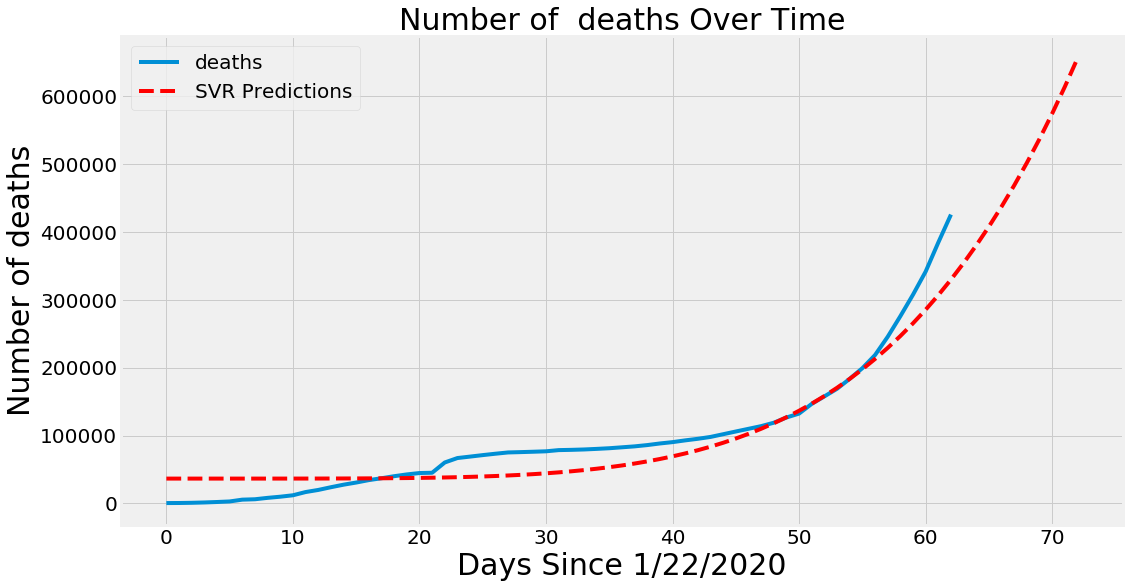

In [21]:
plot_predictions(adjusted_dates, world_cases, svm_pred, 'SVR Predictions', 'red')

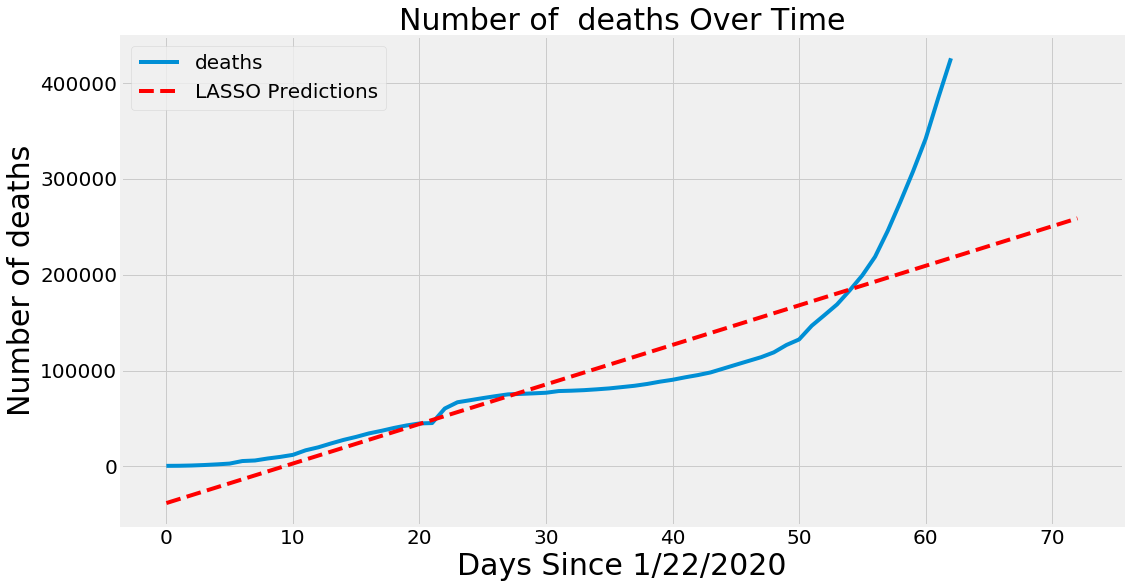

In [22]:
plot_predictions(adjusted_dates, world_cases, lasso_pred, 'LASSO Predictions', 'red')